In [40]:
import tensorflow as tf
import numpy as np
from help_func import *
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy import ndimage
import random
import skfmm

In [2]:
file = Image.open('final/crop_data/cylinder/cylinder.png')
cyl_in = np.array(file)
cyl_in = skfmm.distance(cyl_in,dx=0.000002)
cyl_in = range_scaling(cyl_in)

In [3]:
file = Image.open('final/crop_data/sq_0/sq_0.png')
sq0_in = np.array(file)
sq0_in = skfmm.distance(sq0_in,dx=0.000002)
sq0_in = range_scaling(sq0_in)

In [4]:
file = Image.open('final/crop_data/sq_15/sq_15.png')
sq15_in = np.array(file)
sq15_in = skfmm.distance(sq15_in,dx=0.000002)
sq15_in = range_scaling(sq15_in)

In [5]:
file = Image.open('final/crop_data/sq_30/sq_30.png')
sq30_in = np.array(file)
sq30_in = skfmm.distance(sq30_in,dx=0.000002)
sq30_in = range_scaling(sq30_in)

In [6]:
file = Image.open('final/crop_data/sq_45/sq_45.png')
sq45_in = np.array(file)
sq45_in = skfmm.distance(sq45_in,dx=0.000002)
sq45_in = range_scaling(sq45_in)

In [7]:
file = Image.open('final/crop_data/foil/foil.png')
foil = np.array(file)
foil = skfmm.distance(foil,dx=0.000002)
foil = range_scaling(foil)

In [8]:
file = Image.open('final/crop_data/bike/bike.png')
bike = np.array(file)
bike = skfmm.distance(bike,dx=0.000002)
bike = range_scaling(bike)

In [9]:
file_path = 'final/crop_data/cylinder'
cyl_tar,cyl_u = get_labels(file_path=file_path)
file_path = 'final/crop_data/sq_0'
sq0_tar,sq0_u = get_labels(file_path=file_path)
file_path = 'final/crop_data/sq_15'
sq15_tar,sq15_u = get_labels(file_path=file_path)
file_path = 'final/crop_data/sq_30'
sq30_tar,sq30_u = get_labels(file_path=file_path)
file_path = 'final/crop_data/sq_45'
sq45_tar,sq45_u = get_labels(file_path=file_path)
file_path = 'final/crop_data/foil'
foil_tar,foil_u = get_labels(file_path=file_path)
file_path = 'final/crop_data/bike'
bike_tar,bike_u = get_labels_bike(file_path=file_path)

In [10]:
labels = cyl_tar + sq0_tar + sq15_tar + sq30_tar + sq45_tar + foil_tar + bike_tar
features = [cyl_in]*25 + [sq0_in]*25 + [sq15_in]*25 + [sq30_in]*25 +[sq45_in]*25 + [foil]*25 + [bike]*29
u = cyl_u + sq0_u + sq15_u + sq30_u + sq45_u + foil_u + bike_u
u = range_scaling(np.array(u))
del cyl_in, cyl_u, sq0_u, sq15_u, sq30_u, sq45_u, sq0_in, sq15_in, sq30_in, sq45_in,foil_u,bike_u,foil,bike
del sq0_tar, sq15_tar, sq30_tar, sq45_tar,

In [17]:
graph = tf.Graph()

In [16]:
batch_size = 15
filter_size = 8
a = []
gated = True
nonlinearity = set_nonlinearity('relu')
keep_prob=1.0
n_channels = 3

In [18]:
with graph.as_default():
    tf_x = tf.placeholder(shape=[batch_size,128,256,1],dtype=tf.float32)
    tf_y = tf.placeholder(shape=[batch_size,128,256,n_channels],dtype=tf.float32)
    
    x = res_block(tf_x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = 2 * filter_size
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, stride=2, gated=gated)
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = 2 * filter_size
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, stride=2, gated=gated)
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = 2 * filter_size
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, stride=2, gated=gated)
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = 2 * filter_size
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, stride=2, gated=gated)
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = int(filter_size /2)
    x = transpose_conv_layer(x, 3, 2, filter_size)
    x = res_block(x, a=a[-1], filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    
    
    filter_size = int(filter_size /2)
    x = transpose_conv_layer(x, 3, 2, filter_size)
    x = res_block(x, a=a[-2], filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    
    
    filter_size = int(filter_size /2)
    x = transpose_conv_layer(x, 3, 2, filter_size)
    x = res_block(x, a=a[-3], filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    
    
    filter_size = int(filter_size /2)
    x = transpose_conv_layer(x, 3, 2, filter_size)
    x = res_block(x, a=a[-4], filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    
    logits = conv_layer(x, 3, 1, n_channels)
    logits = tf.nn.tanh(logits)
    logits = tf.nn.relu(logits)
    
    loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(logits,tf_y)))
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)


In [19]:
sess = tf.InteractiveSession(graph=graph)
tf.global_variables_initializer().run()
for i in range(1500):
    a,b = generate_batch(features,labels,u,n_channels=n_channels,batch_size=batch_size)
    feed_dict = {
        tf_x:a,
        tf_y:b
    }
    _,l = sess.run([optimizer,loss],feed_dict=feed_dict)
    if i%200 ==0:
        print(l)

0.89125
0.284798
0.226628
0.185456
0.18779
0.173748
0.16074
0.133624


In [ ]:
##testing

In [20]:
a,b = generate_batch(features,labels,u,n_channels=n_channels,batch_size=batch_size,mode=test)

In [21]:
g = sess.run(logits,feed_dict={tf_x:a})

In [43]:
#making the bike boundary for clear contours
sample = Image.open('final/crop_data/bike/bike.png')
sample = np.array(sample)
index = np.where(sample==0)
bike = g[8]
for i,j in zip(index[0],index[1]):
    bike[i,j,:] = 0

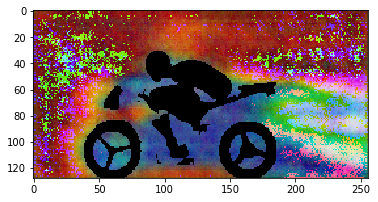

In [57]:
plt.imshow(bike)

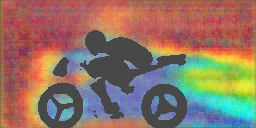

In [97]:
from scipy.misc import toimage
bike = toimage(bike)
from PIL import ImageFilter
bike.filter(ImageFilter.ModeFilter)

(<matplotlib.axes._subplots.AxesSubplot at 0x12abb9ac8>,
 <matplotlib.text.Text at 0x127582198>)

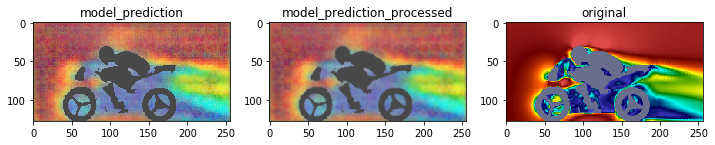

In [96]:
import cv2
img = cv2.imread('/Users/yeswanthcheekati/Desktop/ard.png')
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
plt.figure(figsize=(12,8))
plt.subplot(131),plt.imshow(bike),plt.title('model_prediction')
plt.subplot(132),plt.imshow(ImageEnhance.Sharpness(bike).enhance(0.01)),plt.title('model_prediction_processed')
plt.subplot(133),plt.imshow(b[8]),plt.title('original')
plt.imsave('/Users/yeswanthcheekati/Desktop/')